<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy/blob/main/jupyter/basic_OOK_transmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulate a basic OOK transmission system

In [1]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install . 

In [2]:
import numpy as np
from commpy.utilities  import upsample
from optic.models import mzm, photodiode
from optic.metrics import signal_power
from optic.dsp import firFilter, pulseShape
from optic.core import parameters
from optic.plot import eyediagram
import matplotlib.pyplot as plt
from scipy.special import erfc

from scipy.constants import c
from optic.amplification import edfaSM,OSA

import os.path as path

#import logging as logg
#logg.getLogger().setLevel(logg.INFO)
#logg.basicConfig(format='%(message)s')

In [3]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
figsize(10, 3)

### Intensity modulation (IM) with On-Off Keying (OOK)

In [5]:
# simulation parameters
SpS = 16

Rs = 10e9 # Symbol rate (for OOK case Rs = Rb)
Tsymb = 1/Rs # Symbol period in seconds
Fs = 1/(Tsymb/SpS) # Signal sampling frequency (samples/second)
Ts = 1/Fs # Sampling period

Pi_dBm = -16 # optical signal power at modulator input in dBm

# MZM parameters
Vπ = 2
Vb = -Vπ/2
Pi = 10**(Pi_dBm/10)*1e-3 # optical signal power in W at the MZM input

# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size=100000)
n = np.arange(0, bitsTx.size)

# map bits to electrical pulses
symbTx = 2*bitsTx-1
symbTx = symbTx/np.sqrt(signal_power(symbTx))

# upsampling
symbolsUp = upsample(symbTx, SpS)

# typical NRZ pulse
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# pulse formatting
sigTx = firFilter(pulse, symbolsUp)

# optical modulation
Ai = np.sqrt(Pi)*np.ones(sigTx.size)
sigTxo = mzm(Ai, sigTx, Vπ, Vb)

print('Average power of the modulated optical signal [mW]: %.3f mW'%(signal_power(sigTxo)/1e-3))
print('Average power of the modulated optical signal [dBm]: %.3f dBm'%(10*np.log10(signal_power(sigTxo)/1e-3)))

Average power of the modulated optical signal [mW]: 0.013 mW
Average power of the modulated optical signal [dBm]: -19.005 dBm


c:\Users\Adolfo\mambaforge\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


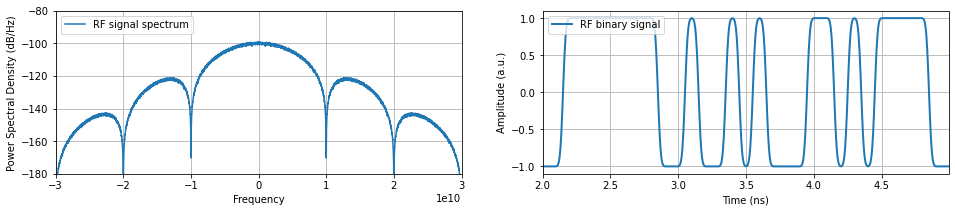

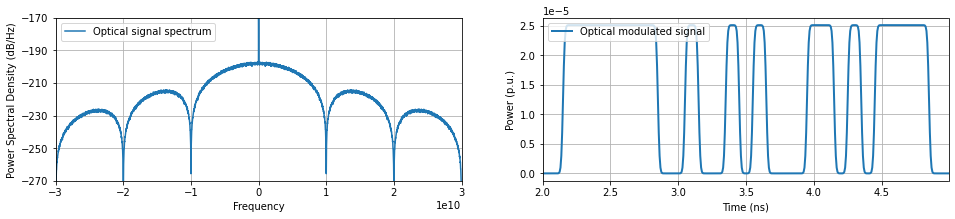

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(16,3))
interval = np.arange(16*20,16*50)
t = interval*Ts/1e-9

# plot psd
axs[0].set_xlim(-3*Rs,3*Rs);
axs[0].set_ylim(-180,-80);
axs[0].psd(sigTx,Fs=Fs, NFFT = 16*1024, sides='twosided', label = 'RF signal spectrum')
axs[0].legend(loc='upper left');

axs[1].plot(t, sigTx[interval], label = 'RF binary signal', linewidth=2)
axs[1].set_ylabel('Amplitude (a.u.)')
axs[1].set_xlabel('Time (ns)')
axs[1].set_xlim(min(t),max(t))
axs[1].legend(loc='upper left')
axs[1].grid()

fig, axs = plt.subplots(1, 2, figsize=(16,3))
# plot psd
axs[0].set_xlim(-3*Rs,3*Rs);
axs[0].set_ylim(-270,-170);
axs[0].psd(np.abs(sigTxo)**2, Fs=Fs, NFFT = 16*1024, sides='twosided', label = 'Optical signal spectrum')
axs[0].legend(loc='upper left');

axs[1].plot(t, np.abs(sigTxo[interval])**2, label = 'Optical modulated signal', linewidth=2)
axs[1].set_ylabel('Power (p.u.)')
axs[1].set_xlabel('Time (ns)')
axs[1].set_xlim(min(t),max(t))
axs[1].legend(loc='upper left')
axs[1].grid()

## Without optical amplification

### Direct-detection (DD) pin receiver model

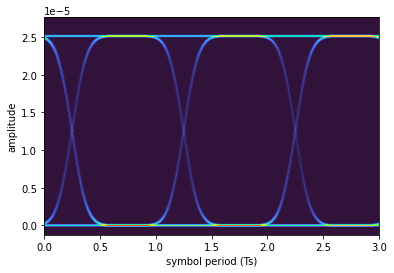

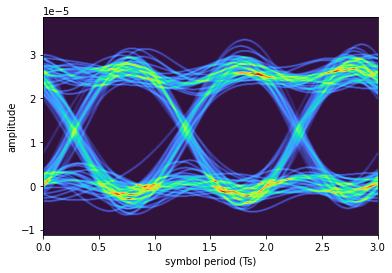

In [7]:
# ideal photodiode (noiseless, no bandwidth limitation)
paramPD = parameters()
paramPD.ideal = True
I_Rx_ideal = photodiode(sigTxo.real, paramPD)

# noisy photodiode (thermal noise + shot noise + bandwidth limitation)
paramPD = parameters()
paramPD.ideal = False
paramPD.B = Rs
paramPD.Fs = Fs

I_Rx = photodiode(sigTxo.real, paramPD)

discard = 100

eyediagram(I_Rx_ideal[discard:-discard].copy(), I_Rx.size-2*discard, SpS, plotlabel='signal at Tx', ptype='fancy')
eyediagram(I_Rx[discard:-discard].copy(), I_Rx.size-2*discard, SpS, plotlabel='signal at Rx', ptype='fancy')

I0 = -0.14 
I1 = 2.27 
σ0 = 0.17 
σ1 = 0.17 
Optimal decision threshold Id = 1.07 
Q = 7.25 

Number of counted errors = 0 
BER = 0.00e+00 
Pb = 2.12e-13 


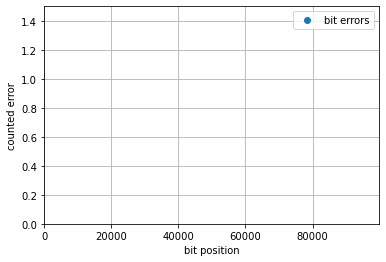

In [8]:
I_Rx = I_Rx/np.std(I_Rx)

# capture samples in the middle of signaling intervals
I_Rx = I_Rx[0::SpS]

# get received signal statistics
I1 = np.mean(I_Rx[bitsTx==1]) # average value of I1
I0 = np.mean(I_Rx[bitsTx==0]) # average value of I0

σ1 = np.std(I_Rx[bitsTx==1]) # standard deviation σ1 of I1
σ0 = np.std(I_Rx[bitsTx==0]) # standard deviation σ0 of I0

Id = (σ1*I0 + σ0*I1)/(σ1 + σ0) # optimal decision threshold
Q = (I1-I0)/(σ1 + σ0) # factor Q

print('I0 = %.2f '%(I0))
print('I1 = %.2f '%(I1))
print('σ0 = %.2f '%(σ0))
print('σ1 = %.2f '%(σ1))
print('Optimal decision threshold Id = %.2f '%(Id))
print('Q = %.2f \n'%(Q))

# Apply the optimal decision rule
bitsRx = np.empty(bitsTx.size)
bitsRx[I_Rx> Id] = 1
bitsRx[I_Rx<= Id] = 0

discard = 100
err = np.logical_xor(bitsRx[discard:bitsRx.size-discard], bitsTx[discard:bitsTx.size-discard])
BER = np.mean(err)

Pb = 0.5*erfc(Q/np.sqrt(2)) # theoretical error probability
print('Number of counted errors = %d '%(err.sum()))
print('BER = %.2e '%(BER))
print('Pb = %.2e '%(Pb))

err = err*1.0
err[err==0] = np.nan

plt.plot(err,'o', label = 'bit errors')
plt.vlines(np.where(err>0), 0, 1)
plt.xlabel('bit position')
plt.ylabel('counted error')
plt.legend()
plt.grid()
plt.ylim(0, 1.5)
plt.xlim(0,err.size);

### Optical amplification

In [9]:
# EDFA parameters
param_edfa = parameters()
# gain control
param_edfa.type     = "AGC"
param_edfa.value    = 20 #dB
# pid - gain control
param_edfa.kp = 2e-3
param_edfa.ki = 0
param_edfa.kd = 0
# pump information
param_edfa.forPump  = {'pump_signal': np.array([100e-3]), 'pump_lambda': np.array([980e-9])}
param_edfa.bckPump  = {'pump_signal': np.array([000e-3]), 'pump_lambda': np.array([980e-9])}
# giles parameters
param_edfa.file     = 'giles_MP980.dat'
param_edfa.fileunit = 'nm'
param_edfa.gmtc     = 'Bessel'
param_edfa.tol      = 0.05
param_edfa.tolCtrl  = 0.5
# ASE
param_edfa.noiseBand= 1.25e9

In [10]:
if 'google.colab' in str(get_ipython()):  
  param_edfa.file = path.join(path.abspath(path.join("../")), 'OptiCommPy', 'optic', 'ampParams', param_edfa.file)
else:
  param_edfa.file = path.join(path.abspath(path.join("../")), 'optic', 'ampParams', param_edfa.file)

In [11]:
Fc = c/1550e-9 # central wavelength
Nmodes = 1     # number of modes
sigTxo = np.reshape(sigTxo, (len(sigTxo), 1))
lenFrqSg, isy = np.shape(sigTxo)
simOpticalBand = (Fs*(c/Fc)**2)/c
tx_pw = np.sum(1000*np.mean(sigTxo * np.conj(sigTxo), axis = 0).real)

In [12]:
# information TX
print('Sample rate [THz]: %5.3f' %(1e-12*Fs))
print('Time window [ns]:  %5.3f' %(1e9*lenFrqSg/Fs))
print('Central wavelength [nm]: %6.2f' %(1e9*c/Fc))
print('Simulation window  [nm]: %f - [%6.2f nm - %6.2f nm]' 
      %(1e9*simOpticalBand, 1e9*(c/Fc-simOpticalBand/2), 1e9*(c/Fc+simOpticalBand/2)))
print('Frequency spacing [GHz]: %f' %(1e-9*Fs/lenFrqSg))
print('Number of points: %d' %(lenFrqSg))
print('Number of modes: %d' %(Nmodes))
print('Average power - TX [mW] : %.3f mW' %(tx_pw))
print('Average power - TX [dBm] : %.3f dBm' %(10*np.log10(tx_pw)))

Sample rate [THz]: 0.160
Time window [ns]:  10000.000
Central wavelength [nm]: 1550.00
Simulation window  [nm]: 1.282220 - [1549.36 nm - 1550.64 nm]
Frequency spacing [GHz]: 0.000100
Number of points: 1600000
Number of modes: 1
Average power - TX [mW] : 0.013 mW
Average power - TX [dBm] : -19.005 dBm


<AxesSubplot:xlabel='Wavelength [nm]', ylabel='Magnitude [dBm]'>

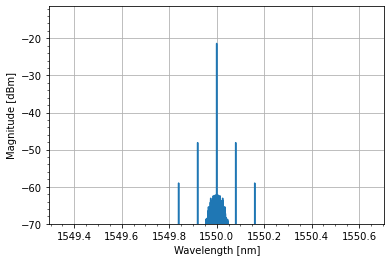

In [13]:
OSA(sigTxo, Fs, Fc)

In [15]:
Eout, PumpF, PumpB, noisef = edfaSM(sigTxo, Fs, Fc, param_edfa)

In [16]:
rx_pw = np.sum(1000*np.mean(Eout * np.conj(Eout), axis = 0).real)
print('Forward pump  - [mW] : %.3f' %(1e3*PumpF[0]))
print('Backward pump - [mW] : %.3f' %(1e3*PumpB[1]))
print('Average power - RX amp [mW] : %.3f' %(rx_pw))
print('Average power - RX amp [dBm] : %.3f' %(10*np.log10(rx_pw)))
print('Gain [dB]: %.3f' %(10*np.log10(rx_pw/tx_pw)))

Forward pump  - [mW] : 13.631
Backward pump - [mW] : 0.000
Average power - RX amp [mW] : 1.391
Average power - RX amp [dBm] : 1.433
Gain [dB]: 20.438


<AxesSubplot:xlabel='Wavelength [nm]', ylabel='Magnitude [dBm]'>

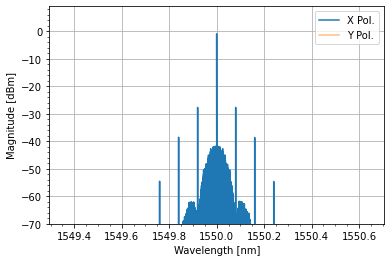

In [17]:
OSA(Eout, Fs, Fc)

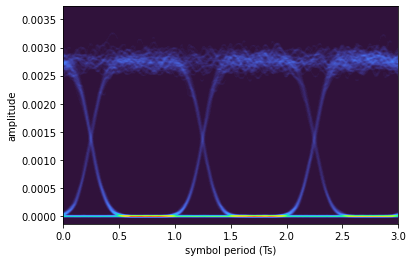

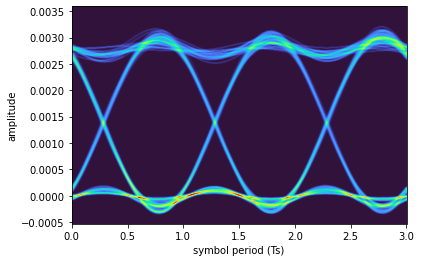

In [18]:
# ideal photodiode (noiseless, no bandwidth limitation)
paramPD = parameters()
paramPD.ideal = True
I_Rx_Amp_ideal = photodiode(Eout[:,0].real, paramPD)

# noisy photodiode (thermal noise + shot noise + bandwidth limitation)
paramPD = parameters()
paramPD.ideal = False
paramPD.B = Rs
paramPD.Fs = Fs

I_Rx_Amp = photodiode(Eout[:,0].real, paramPD)

discard = 100

eyediagram(I_Rx_Amp_ideal[discard:-discard].copy(), I_Rx_Amp.size-2*discard, SpS, plotlabel='signal at Tx', ptype='fancy')
eyediagram(I_Rx_Amp[discard:-discard].copy(), I_Rx_Amp.size-2*discard, SpS, plotlabel='signal at Rx', ptype='fancy')

I0 = -0.14 
I1 = 2.30 
σ0 = 0.06 
σ1 = 0.07 
Optimal decision threshold Id = 1.02 
Q = 17.96 

Number of counted errors = 0 
BER = 0.00e+00 
Pb = 1.98e-72 


(0.0, 99800.0)

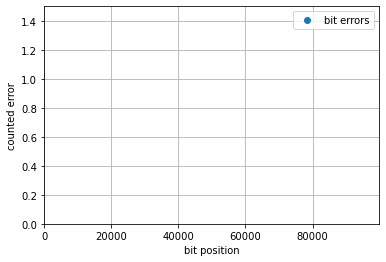

In [19]:
I_Rx_Amp = I_Rx_Amp/np.std(I_Rx_Amp)

# capture samples in the middle of signaling intervals
I_Rx_Amp = I_Rx_Amp[0::SpS]

# get received signal statistics
I1 = np.mean(I_Rx_Amp[bitsTx==1]) # average value of I1
I0 = np.mean(I_Rx_Amp[bitsTx==0]) # average value of I0

σ1 = np.std(I_Rx_Amp[bitsTx==1]) # standard deviation σ1 of I1
σ0 = np.std(I_Rx_Amp[bitsTx==0]) # standard deviation σ0 of I0

Id = (σ1*I0 + σ0*I1)/(σ1 + σ0) # optimal decision threshold
Q = (I1-I0)/(σ1 + σ0) # factor Q

print('I0 = %.2f '%(I0))
print('I1 = %.2f '%(I1))
print('σ0 = %.2f '%(σ0))
print('σ1 = %.2f '%(σ1))
print('Optimal decision threshold Id = %.2f '%(Id))
print('Q = %.2f \n'%(Q))

# Apply the optimal decision rule
bitsRx = np.empty(bitsTx.size)
bitsRx[I_Rx_Amp> Id] = 1
bitsRx[I_Rx_Amp<= Id] = 0

discard = 100
err = np.logical_xor(bitsRx[discard:bitsRx.size-discard], bitsTx[discard:bitsTx.size-discard])
BER = np.mean(err)

Pb = 0.5*erfc(Q/np.sqrt(2)) # theoretical error probability
print('Number of counted errors = %d '%(err.sum()))
print('BER = %.2e '%(BER))
print('Pb = %.2e '%(Pb))

err = err*1.0
err[err==0] = np.nan

plt.plot(err,'o', label = 'bit errors')
plt.vlines(np.where(err>0), 0, 1)
plt.xlabel('bit position')
plt.ylabel('counted error')
plt.legend()
plt.grid()
plt.ylim(0, 1.5)
plt.xlim(0,err.size)